# Bank Churn Prediction

## Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

## Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

## Data Dictionary

* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer 
* CreditScore: It defines the credit history of the customer.  
* Geography: A customer’s location    
* Gender: It defines the Gender of the customer   
* Age: Age of the customer     
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
* EstimatedSalary: Estimated salary 
* isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
* Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
>* 0=No ( Customer did not leave the bank )
>* 1=Yes ( Customer left the bank )



In [1]:
# Course: Introduction to Neural Networks
# Project: Bank Churn Prediction
# Student: Sameer Girolkar
# Date: Mar 4, 2022

In [2]:
# efrom google.colab import files
# fils.upload()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from random import shuffle
from collections import Counter
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
)
import tensorflow as tf
from keras import callbacks
from keras import regularizers
from keras import backend
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, InputLayer, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")


## Functions for EDA and Visualizations

In [4]:
# function to plot histogram and barplot together
def histogram_boxplot(
    data, feature, figsize=(12, 7), kde=False, bins=None, hue=None, element="bars"
):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet", hue=hue
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data,
        x=feature,
        kde=kde,
        ax=ax_hist2,
        bins=bins,
        palette="winter",
        hue=hue,
        element=element,
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, hue=hue, element=element
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")

In [5]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None, hue=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    hue: Grouping variable
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 5, 5))
    else:
        plt.figure(figsize=(n + 5, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
        hue=hue,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [6]:
# function to create box-plots by category
def box_plot_by_cat(data, category_col, y, n=None):
    """
    Boxplot by category

    data: dataframe
    category_col: column for which the boxplot will be created
    y: independent variable
    n: no of values to plot
    """
    count = data[category_col].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
    sns.boxplot(
        x=category_col,
        y=y,
        data=data,
        order=data[category_col].value_counts().index[:n].sort_values(),
    )
    plt.xticks(rotation=90)
    plt.show()

In [7]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(
        data[predictor], data[target], margins=True
    ).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 75)
    tab = pd.crosstab(
        data[predictor], data[target], normalize="index"
    ).sort_values(
        by=sorter, ascending=False
    )
    ax = tab.plot(kind="bar", stacked=True, figsize=(count + 7, 6))

    # for c in ax.containers:
    #     ax.bar_label(c, label_type="center", size=14, fmt="%.2f")

    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    plt.show()

In [8]:
# Removes the limit from the number of displayed columns
pd.set_option("display.max_columns", None)

# Let's set the limit of 200 rows max
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [9]:
# make the graphs look nicer
sns.set(color_codes=True)
sns.set_style("darkgrid")
# light palette for Pivot tables
cm = sns.light_palette("lightblue", as_cmap=True)
sns.set(
    rc={
        "figure.figsize": (15, 15),
        "axes.titlesize": "30",
        "xtick.labelsize": "20",
        "ytick.labelsize": "20",
    }
)

# actually display the graphs instead of generating only the object
%matplotlib inline

## Overview of the Dataset
Let's now read and observe the data

In [10]:
# Read the data
data = pd.read_csv("Churn.csv")

In [11]:
data.shape

(10000, 14)

There are 10000 rows with 14 columns in the data

In [12]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


A look at the sample data indicates that the RowNumber column is a counter and may not contribute to the information.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


* None of the columns have null values
* Most of the columns are numeric

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
CustomerId,10000.00,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


*   Age is right-skewed
*   Balance is right-skewed
*   EstimatedSalary seems to be right-skewed


In [15]:
data.describe(include="object").T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


*   Over 50% of the customers are from France
*   More than 50% male customers

RowNumber and CustomerId columns are assigned to a customer.
<br/>These columns are not really providing any meaningful information about a customer's profile.
<br/>Similarly Surname as well will not contribute
<br/>We should drop these columnns

In [16]:
# lets keep a copy of the data
data_copy = data.copy()

In [17]:
# drop RowNumber and CustomerId columns
data.drop(["RowNumber","CustomerId", "Surname"], axis=1, inplace=True)

Some columns are currently numeric but those are actually categorical. Lets change the type on these.
*   Tenure
*   NumOfProducts
*   HasCrCard
*   IsActiveMember
*   Exited

In [18]:
cat_cols = ["Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember", "Exited"]
for col in cat_cols:
  data[col] = data[col].astype("category")

## EDA

### Univariet Analysis

#### Numeric columns

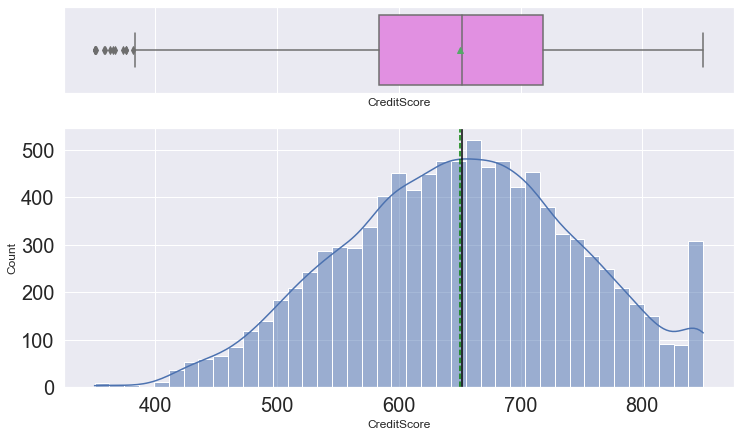

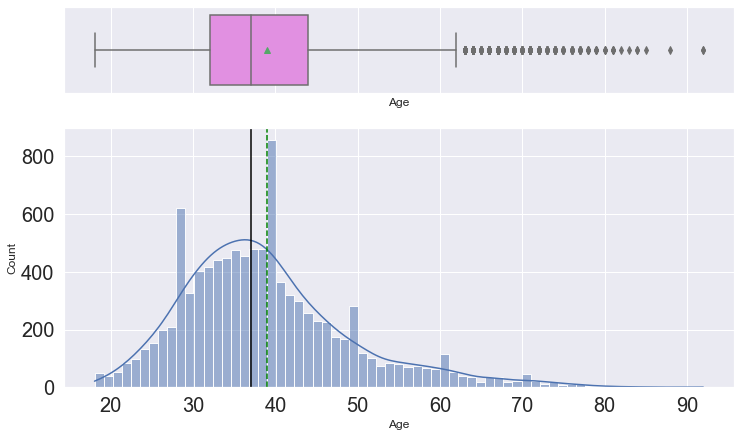

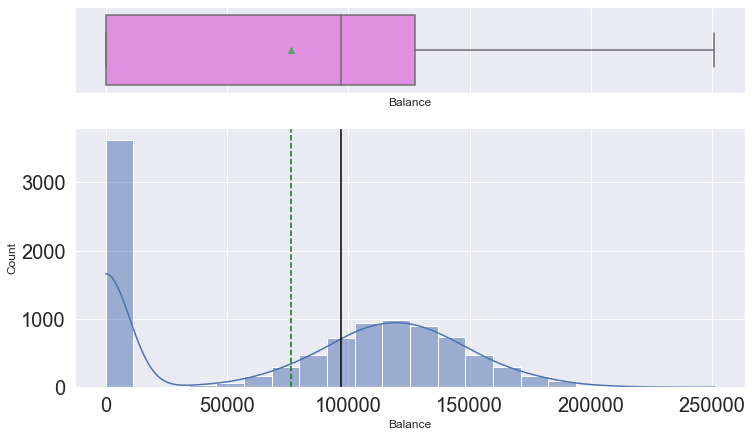

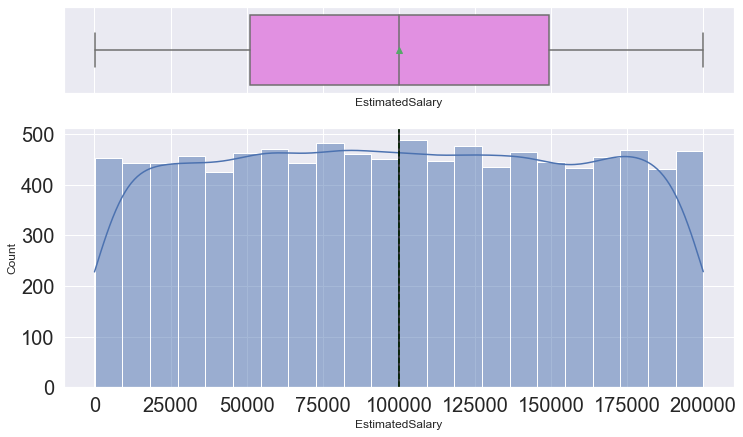

In [19]:
for col in data.columns:
  if data[col].dtypes in ["int64", "float64"]:
    histogram_boxplot(data, col, kde=True)

##### **Observations**

*   **CreditScore**: 
> Credit Score data is slightly left skewed with a spike near 850 which is the highest CerditScore possible.<br/>There are some outliers on the left side for credit scores.
*   **Age**:
> Age data is right-skewed but there are no outliers<br/>Most of the customers are in their 30s to 50s
*  **Balance**:
> Most costumers have 0 balance<br/>Non-zero balance data is evenly distributed
*  **EstimatedSalary**
> Estimated Salary data is evenly distributed








#### Categorical columns

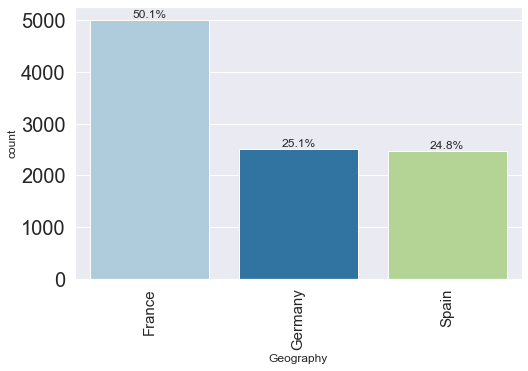

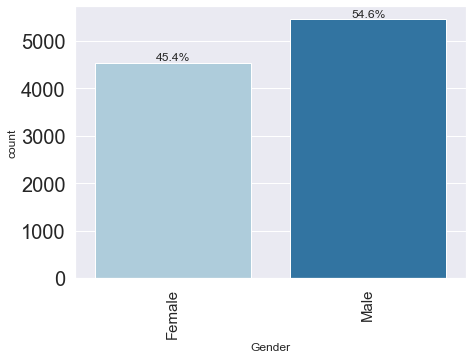

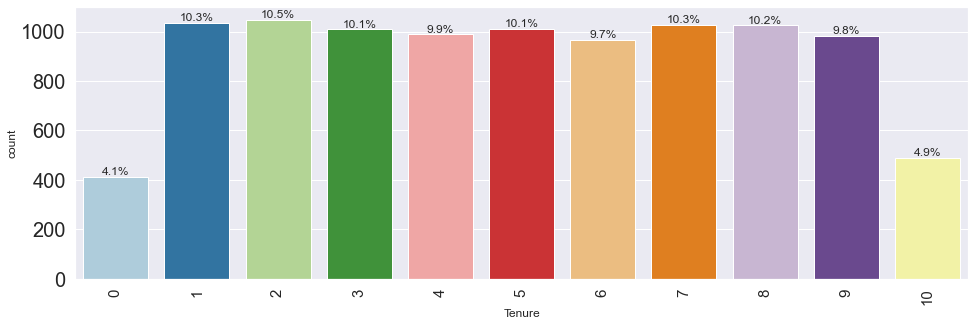

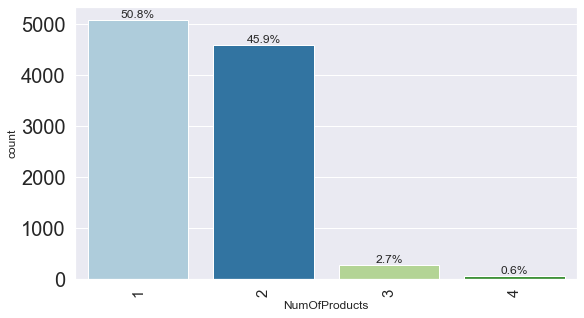

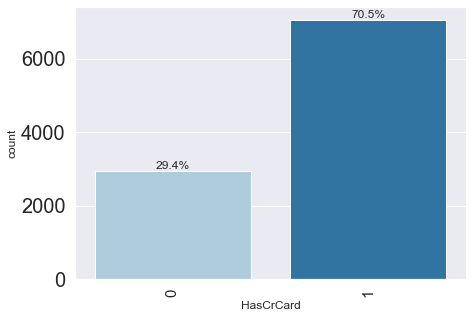

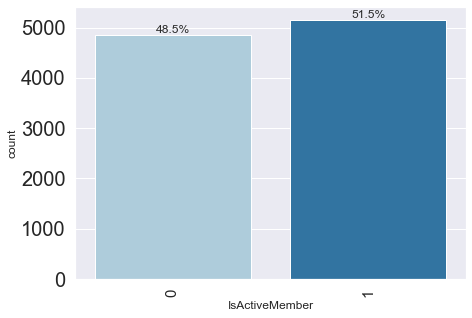

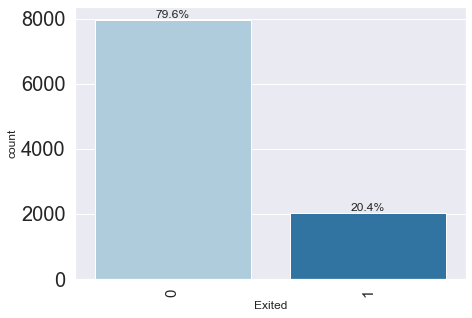

In [20]:
for col in data.columns:
  if str(data.dtypes[col]) in ["object", "category"]:
    labeled_barplot(data, col, perc=True)

##### **Observations**

*   Gegrophy
> Almost 50% of the customers are from France, Germany and Spain have nearly 25% of customers
*   Gender
> 45.4% Customers are Females and 54.6% Male
*   Tenure
> There are nearly 10% customers in each Tenure bucket, except 0 and 10
*   NumOfProducts
> Just over 50% customers have only one producr and another 45.9% have 2.<br/>Very few customers have 3 or 4 products
*   HasCrCard
> 70.5% Customers have Credit Cards rest 29.4% dont.
*   IsActiveMember
> 48.5% customers are not active. 51.5% are active.
*   Exited
> 20.4% customer have exited, 79.6% are still customers.



### Bivariet Analysis

Lets take a look at the correlations between the columns

#### Heatmap

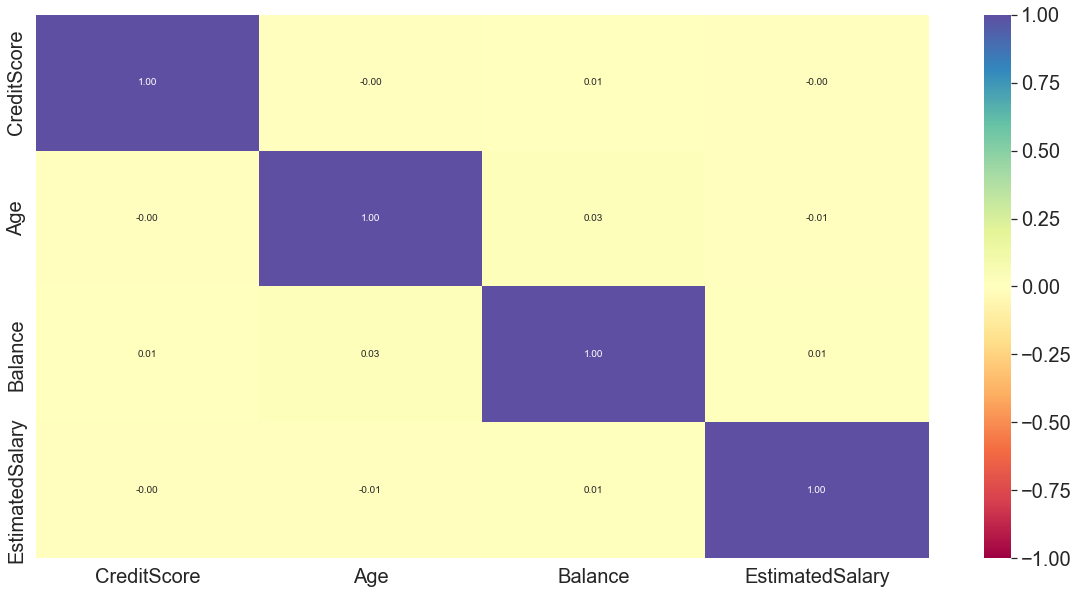

In [21]:
plt.figure(figsize=(20, 10))
hm = sns.heatmap(
    data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

###### **Observations**
None of the numeric columns are coreleated with each other

#### Pair-Plot

<Figure size 1080x504 with 0 Axes>

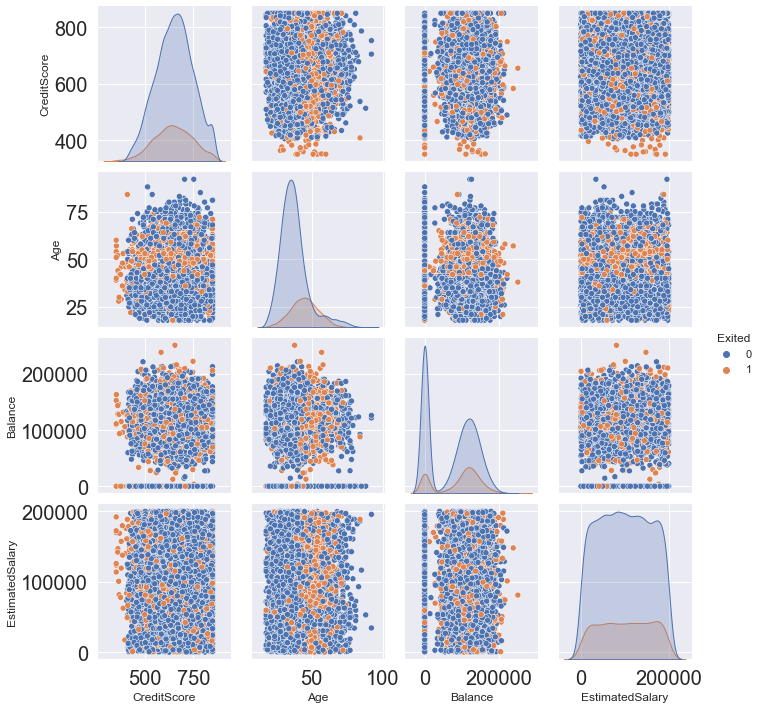

In [22]:
plt.figure(figsize=(15, 7))
sns.pairplot(data=data, diag_kind="kde", hue="Exited")
plt.show()

##### **Observations**

*   Customers with credit scores less than 400 are likely to churn
*   Most of the users who exited are around 50 years of age



#### Categorical colums vs. Target

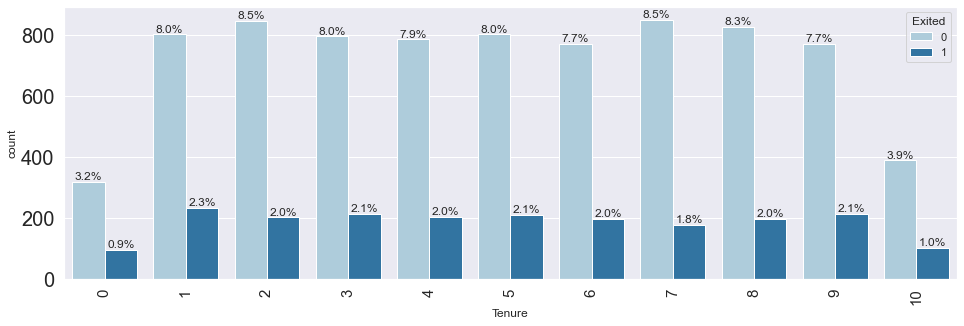

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
---------------------------------------------------------------------------


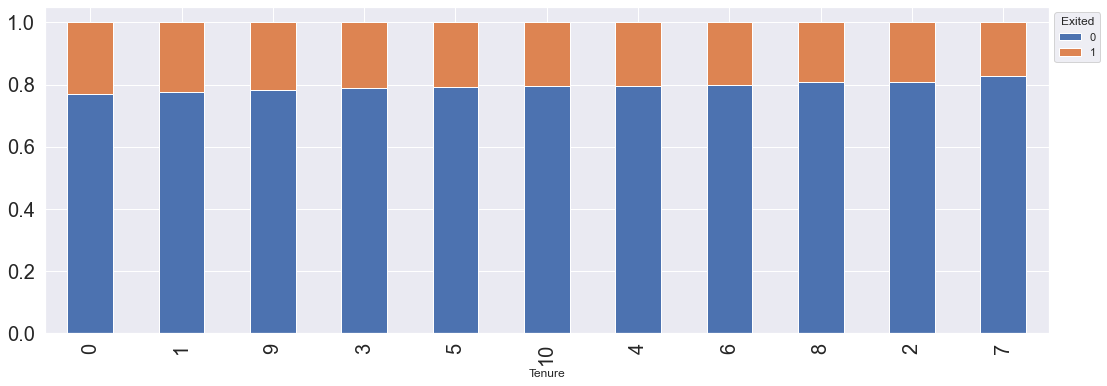

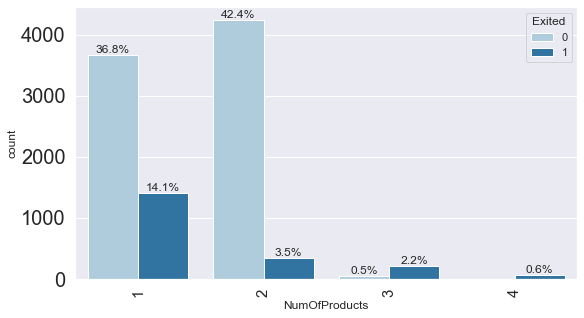

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
---------------------------------------------------------------------------


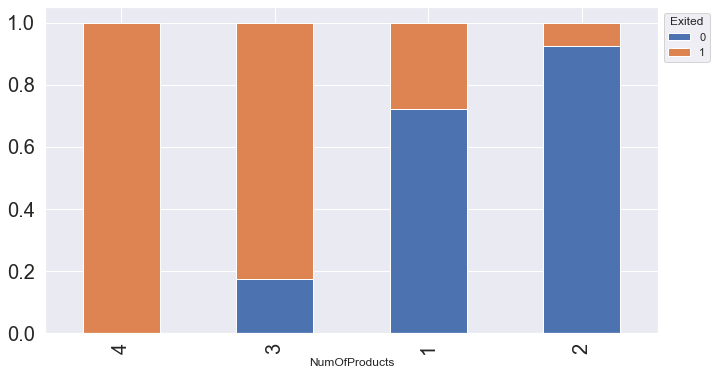

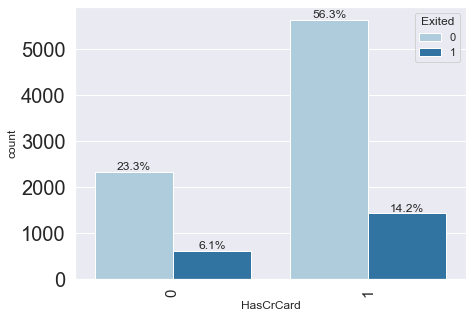

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
---------------------------------------------------------------------------


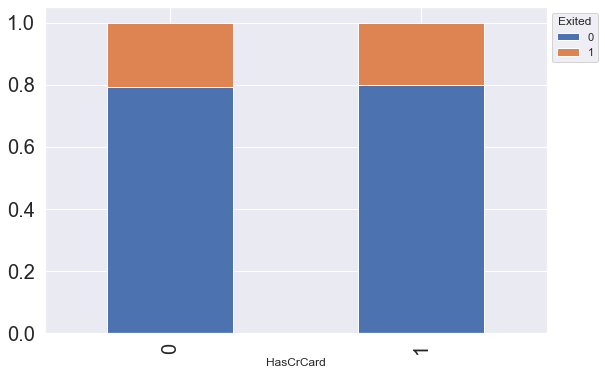

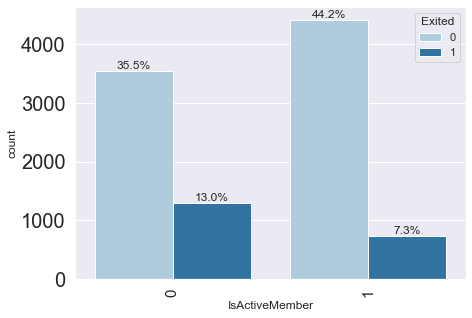

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
---------------------------------------------------------------------------


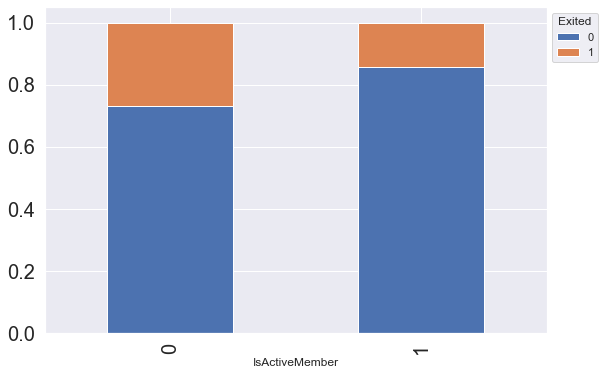

In [23]:
# Function ot plot Labled barplot 
# and stacked barplot for the category with target
def barplots_for_cat(cat_col, target="Exited"):
    labeled_barplot(data=data, feature=cat_col, hue=target, perc=True)
    stacked_barplot(data=data, predictor=cat_col, target=target)

for col in cat_cols:
  if col != "Exited":
    barplots_for_cat(col)

##### **Observations**

1.   ***Tenure***: There is no clear relation of tenure with customer exiting
2.   ***Number Of Products***: All the customers with 4 products have exited<br/>Similarly most customers with 3 products also have exited.
3.   ***Has Credit Card***: Credit card does not have direct relation with customer exiting
4.   ***Active Member***: Activer customers are less likely to exit




## Data Pre-processing

### Data split
Let's split the data in to tagret and deependent set<br/>
And then the training and test sets


In [24]:
# target variable and predictors
X = data.drop("Exited", axis=1)
Y = data["Exited"]

In [25]:
# create dummies
X = pd.get_dummies(X,drop_first=True)

# we will need to convert the dataset to float 
# in order to be able to convert it into tensors later.
X = X.astype('float32') 

In [26]:
# Splitting the dataset into the Training and Testing set.

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify = Y)
#Splitting the train set into  dev set and training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

### Scaling the data

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [28]:
X_train.shape

(6400, 22)

## Model Building
Let's start the model building process




### Model evaluation criteria

**A model can make wrong predictions in one of the following two ways**
1.   Predict a customer will not exit when they actually exit
2.   Predict a customer will exit when theu actuallu do not

Of the above two, the first case means bigger loss for the bank.<br>
Because of this we will be using Recall as the criteria for model evaluation in this case.

In [29]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Base model

In [30]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [31]:
# Initializing the ANN
model = Sequential()
# This adds the input layer
model.add(Dense(activation = 'relu', input_dim = 22, units=32))
#Add 1st hidden layer
model.add(Dense(64, activation='relu'))
# Adding the output layer
# Use sigmoid because we want probability outcomes
model.add(Dense(1, activation = 'sigmoid')) 

2022-03-12 10:43:29.466483: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# Create optimizer with default learning rate
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                736       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


#### Training the Moodel

In [34]:
#fitting the model
history=model.fit(X_train,y_train, epochs=30,validation_split=0.2)

Epoch 1/30
160/160 [==============================] - 1s 2ms/step - loss: 0.4538 - accuracy: 0.8061 - val_loss: 0.4074 - val_accuracy: 0.8281
Epoch 2/30
160/160 [==============================] - 0s 943us/step - loss: 0.3792 - accuracy: 0.8406 - val_loss: 0.3961 - val_accuracy: 0.8258
Epoch 3/30
160/160 [==============================] - 0s 868us/step - loss: 0.3658 - accuracy: 0.8471 - val_loss: 0.3923 - val_accuracy: 0.8445
Epoch 4/30
160/160 [==============================] - 0s 954us/step - loss: 0.3565 - accuracy: 0.8498 - val_loss: 0.3831 - val_accuracy: 0.8406
Epoch 5/30
160/160 [==============================] - 0s 946us/step - loss: 0.3504 - accuracy: 0.8543 - val_loss: 0.3822 - val_accuracy: 0.8328
Epoch 6/30
160/160 [==============================] - 0s 947us/step - loss: 0.3448 - accuracy: 0.8582 - val_loss: 0.3770 - val_accuracy: 0.8430
Epoch 7/30
160/160 [==============================] - 0s 969us/step - loss: 0.3397 - accuracy: 0.8596 - val_loss: 0.3784 - val_accuracy: 0

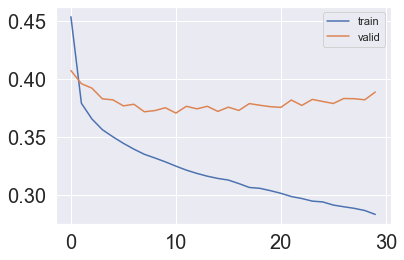

In [35]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### Model Evaluation

In [36]:
score = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3835 - accuracy: 0.8450


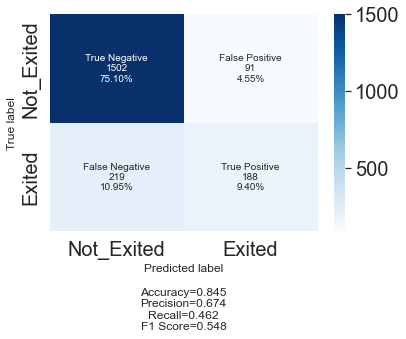

In [37]:
## Confusion Matrix on unsee test set
y_pred1 = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0

cm=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(
  cm, group_names=labels, categories=categories, cmap='Blues'
)

#### Observaations
1.   First model we built has performed very poorly on Recall (46.7%)
2.   we need to tune the model to improve the recall



### Model 2 (Tuned) 

In [38]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [39]:
# Initializing the ANN
# this model adds a new hidden layer.
# Uses kernel_initializer='he_normal'
# adds dropouts
model2 = Sequential()
# This adds the input layer
#Initializing the weights uisng hue_normal 
model2.add(
    Dense(
        activation='relu', 
        input_dim=22, 
        units=32, 
        kernel_initializer='he_normal'
    )
)
model2.add(Dropout(0.5))
#Add 1st hidden layer
model2.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model2.add(Dropout(0.5))
#Add 2nd hidden layer
model2.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model2.add(Dropout(0.5))
# Adding the output layer
# Use sigmoid because we want probability outcomes
model2.add(Dense(1, activation = 'sigmoid', kernel_initializer='he_normal')) 

In [40]:
# Create optimizer with tuned learning rate
# Compile the model
model2.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [41]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                736       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

#### Training the Moodel

In [42]:
#fitting the model
#adding earlystopping callback
es= callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0, 
    mode='min', 
    restore_best_weights= True
)
#add class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

history2=model2.fit(
    X_train,
    y_train, 
    epochs=33, 
    validation_split=0.2, 
    batch_size=500, 
    callbacks=[es], 
    shuffle=True, 
    verbose=1,
    class_weight=class_weights
)

Epoch 1/33
11/11 [==============================] - 0s 12ms/step - loss: 1.1597 - accuracy: 0.4869 - val_loss: 0.6293 - val_accuracy: 0.6750
Epoch 2/33
11/11 [==============================] - 0s 3ms/step - loss: 0.7912 - accuracy: 0.5361 - val_loss: 0.6161 - val_accuracy: 0.7883
Epoch 3/33
11/11 [==============================] - 0s 4ms/step - loss: 0.7033 - accuracy: 0.5846 - val_loss: 0.6336 - val_accuracy: 0.7953
Epoch 4/33
11/11 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6037 - val_loss: 0.6269 - val_accuracy: 0.7961
Epoch 5/33
11/11 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6539 - val_loss: 0.6061 - val_accuracy: 0.8047
Epoch 6/33
11/11 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6887 - val_loss: 0.5927 - val_accuracy: 0.7992
Epoch 7/33
11/11 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6818 - val_loss: 0.5733 - val_accuracy: 0.7984
Epoch 8/33
11/11 [=

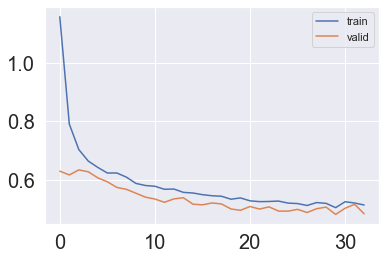

In [43]:
# Capturing learning history per epoch
hist2  = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch

# Plotting accuracy at different epochs
plt.plot(hist2['loss'])
plt.plot(hist2['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### Model Evaluation

In [44]:
score = model2.evaluate(X_test, y_test)

63/63 [==============================] - 0s 688us/step - loss: 0.4725 - accuracy: 0.7770


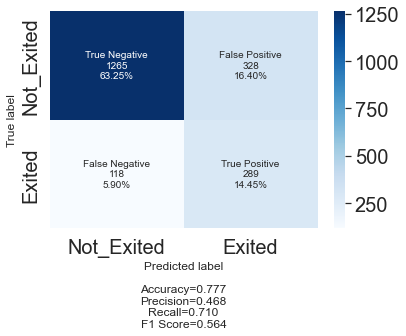

In [45]:
## Confusion Matrix on unsee test set
y_pred1 = model2.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0

cm=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(
  cm, group_names=labels, categories=categories, cmap='Blues'
)

##### Observations
1.   Tuned model is showing much improved recall score on the test data (71%)
2.   For tuning the model we did the following 
> *   Aadded an extra hidden layer to the model
> *   Added drop_outs after each hidden layer
> *   Added Early Stopping callback
> *   Used class weights
> *   Set the leaarning rate







## Conclusion
* We built and tuned a model for the ban to predict if a customer will exit or not.  
* This model can predict correctly 71% of the customers who will exit  
* During EDA of the data three clear observations were noticed. Bank should focus their effors on retaining thes classes of customes.
> 1. Most of the Customers with credit score bellow 400 exited
> 2. All the customers with 4 products and most of the customers with 3 products exited the bank
> 3. Most of the customers who exited were around the age of 50






